<a href="https://colab.research.google.com/github/Sharesingh/scratch-gui/blob/master/Fire_CNN_using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

base_dir = '/content/drive/My Drive/fire_dataset'



datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=64, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=64, 
    subset='validation')

Found 800 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 2))

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'fire': 0, 'not fire': 1}


In [ ]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
!cat labels.txt

fire
not fire

In [ ]:
base_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 2,626,722
Trainable params: 368,738
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [ ]:
epochs = 10

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/10
13/13 [==============================] - 315s 25s/step - loss: 0.7363 - accuracy: 0.8765 - val_loss: 0.2422 - val_accuracy: 0.9497
Epoch 2/10
13/13 [==============================] - 76s 6s/step - loss: 0.0754 - accuracy: 0.9745 - val_loss: 0.1961 - val_accuracy: 0.9397
Epoch 3/10
13/13 [==============================] - 69s 5s/step - loss: 0.0502 - accuracy: 0.9897 - val_loss: 0.1656 - val_accuracy: 0.9447
Epoch 4/10
13/13 [==============================] - 69s 5s/step - loss: 0.0292 - accuracy: 0.9920 - val_loss: 0.1525 - val_accuracy: 0.9548
Epoch 5/10
13/13 [==============================] - 69s 5s/step - loss: 0.0314 - accuracy: 0.9896 - val_loss: 0.1670 - val_accuracy: 0.9497
Epoch 6/10
13/13 [==============================] - 69s 5s/step - loss: 0.0112 - accuracy: 0.9986 - val_loss: 0.1536 - val_accuracy: 0.9598
Epoch 7/10
13/13 [==============================] - 71s 5s/step - loss: 0.0082 - accuracy: 0.9991 - val_loss: 0.1646 - val_accuracy: 0.9548
Epoch 8/10
13/13 [

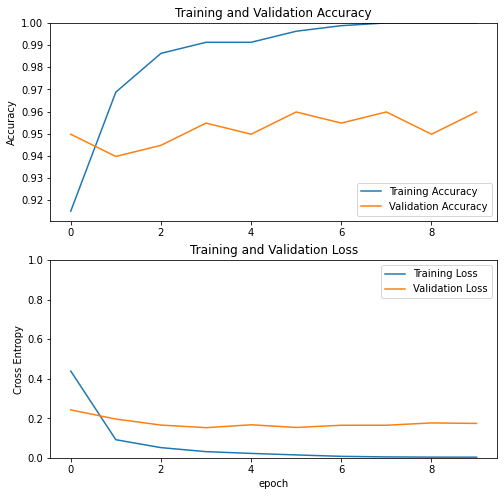

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 2,626,722
Trainable params: 2,230,178
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 58


In [ ]:
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=5, 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 1/5
13/13 [==============================] - 97s 7s/step - loss: 0.2816 - accuracy: 0.8945 - val_loss: 0.1750 - val_accuracy: 0.9497
Epoch 2/5
13/13 [==============================] - 89s 7s/step - loss: 0.1242 - accuracy: 0.9406 - val_loss: 0.1803 - val_accuracy: 0.9497
Epoch 3/5
13/13 [==============================] - 89s 7s/step - loss: 0.0470 - accuracy: 0.9838 - val_loss: 0.1847 - val_accuracy: 0.9447
Epoch 4/5
13/13 [==============================] - 89s 7s/step - loss: 0.0309 - accuracy: 0.9931 - val_loss: 0.1879 - val_accuracy: 0.9447
Epoch 5/5
13/13 [==============================] - 89s 7s/step - loss: 0.0158 - accuracy: 0.9986 - val_loss: 0.1883 - val_accuracy: 0.9447


In [ ]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [ ]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>